In [1]:
import wrangle as w
import wrangle_Naomi
import env

import pandas as pd
import numpy as np
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

from importlib import reload

In [2]:
reload(w)
df = w.wrangle_zillow()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77028 entries, 0 to 77027
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   parcel_id                 77028 non-null  Int64         
 1   bath_count                77028 non-null  Float64       
 2   bed_count                 77028 non-null  Int64         
 3   calc_bath_and_bed         76764 non-null  Float64       
 4   calc_sqft                 77024 non-null  Int64         
 5   finished_sqft12           73689 non-null  Int64         
 6   fips                      77028 non-null  category      
 7   fireplace_cnt             77028 non-null  Int64         
 8   full_bath_cnt             76764 non-null  Int64         
 9   garage_car_count          77028 non-null  Int64         
 10  garage_sqft               25462 non-null  Int64         
 11  latitude                  77028 non-null  Int64         
 12  longitude         

In [4]:
train, validate, test = w.tvt_split(df)

In [5]:
print("train observations: ", train.shape)
print("validate observations: ", validate.shape)
print("test observations: ", test.shape)

train observations:  (43135, 39)
validate observations:  (18487, 39)
test observations:  (15406, 39)


# explore

### Does having nice outdoor features have a relationship with logerror?

In [6]:
train.head()

,parcel_id,bath_count,bed_count,calc_bath_and_bed,calc_sqft,finished_sqft12,fips,fireplace_cnt,full_bath_cnt,garage_car_count,...,assessment_year,land_value,tax_amount,census_tract_and_block,log_error,transaction_date,air_conditioning_desc,heating_system_desc,property_land_use_desc,outliers
7025,12894764,3.0,5,3.0,2862,2862,6037,0,3,0,...,2016,106103,5404.0,60650466022009,0.318812,2017-02-01,Central,Central,Planned Unit Development,upper
68198,12066663,2.0,2,2.0,956,956,6037,0,2,0,...,2016,85837,2349.6,60373019001027,0.024743,2017-08-22,Central,Central,Condominium,lower
34345,14726680,2.0,2,2.0,1530,1530,6059,0,2,2,...,2016,190961,3622.1,60590219162007,-0.016291,2017-05-10,<NA>,<NA>,Condominium,lower
24333,12499632,1.0,3,1.0,990,990,6037,0,1,0,...,2016,216451,3650.76,60375722014021,-0.036821,2017-04-07,<NA>,Floor/Wall,Single Family Residential,lower
49881,14011102,1.5,2,1.5,1110,1110,6059,0,1,0,...,2016,76580,1994.28,60591101093000,-0.024844,2017-06-26,<NA>,<NA>,Single Family Residential,lower


In [7]:
X3 = train[['garage_car_count', 'pool_count', 'lot_sqft']]

In [8]:
train.shape

(43135, 39)

In [9]:
X3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43135 entries, 7025 to 13356
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   garage_car_count  43135 non-null  Int64
 1   pool_count        43135 non-null  Int64
 2   lot_sqft          43135 non-null  Int64
dtypes: Int64(3)
memory usage: 1.4 MB


In [10]:
kmeans = KMeans(n_clusters = 4).fit(X3)
train['cluster3'] = kmeans.predict(X3)

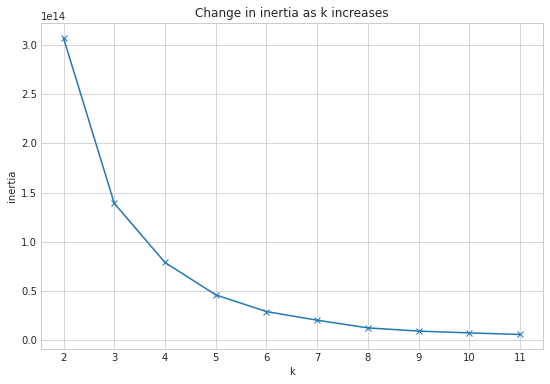

In [11]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [12]:
train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()

/var/folders/h3/mf3_948d1xn0mgz6l997fvlw0000gn/T/ipykernel_42295/887977046.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train.groupby('cluster3')['garage_car_count', 'pool_count', 'lot_sqft'].mean()


,garage_car_count,pool_count,lot_sqft
cluster3,,,
0,0.621775,0.19767,12333.734041
1,0.0,0.4,1078915.9625
2,0.0,0.0,6971010.0
3,0.025929,0.516468,301082.992992


In [13]:
#sns.stripplot(data = train, x = 'log_error', y = 'cluster3')

(array([1.0000e+00, 1.0000e+00, 8.0000e+00, 1.4000e+01, 7.3000e+01,
        3.3088e+04, 9.7620e+03, 1.1500e+02, 6.1000e+01, 1.2000e+01]),
 array([-4.65542037764, -3.8723095432019994, -3.0891987087639996,
        -2.306087874326, -1.5229770398879996, -0.7398662054499994,
        0.04324462898799997, 0.8263554634260002, 1.6094662978640004,
        2.3925771323020006, 3.1756879667400004], dtype=object),
 <BarContainer object of 10 artists>)

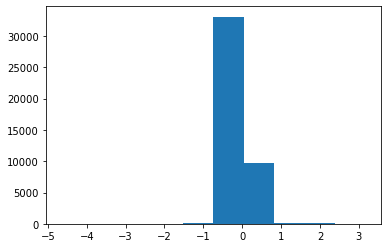

In [16]:
plt.hist(data = train, x = 'log_error')